In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import os
from PIL import Image, ImageEnhance
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [4]:
seed = 123
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
BATCH_SIZE = 31 # 64 in paper
WEIGHT_DECAY = 0
EPOCHS = 1000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [5]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]
        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def plot_image(image, boxes):
    im = np.array(image)
    height, width = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x, labels = x.to(device), labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

def convert_cellboxes(predictions, S=7, C=9):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C+10)
    bboxes1 = predictions[..., C+1:C+5]
    bboxes2 = predictions[..., C+6:C+10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C+5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C+5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    return converted_preds

def cellboxes_to_boxes(out, S=7, C=9):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [6]:
# 168x168
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 4],
    (256, 3, 2),
    ["B", 6],
    (512, 3, 2),
    ["B", 6],
    (864, 3, 1),
    ["B", 4],
    (512, 2, 1),
    (1024, 3, 1),
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

class Yolov1(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()
        self.fcs = self._create_fcs()

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for idx, module in enumerate(config):
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size >= 2 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
        return layers

    def _create_fcs(self, split_size=7, num_boxes=2, num_classes=9):
        S, B, C = split_size, num_boxes, num_classes

        # In paper:
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 864),
            nn.LeakyReLU(0.1),
            nn.Linear(864, S * S * (C + B * 5)),
        )

In [21]:
class customDataset(torch.utils.data.Dataset):
    def __init__(
        self, dir, S=7, B=2, C=9,
    ):
        self.dir = dir
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return 88

    def __getitem__(self, index):
        label_path = os.path.join(self.dir, f"{index}.txt")
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.dir, f"{index}.jpg")
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        # image = ImageEnhance.Contrast(image)
        # image = image.enhance(2)

        image = image.convert('L')
        image = self.transform(image)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, self.C+1:self.C+5] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [8]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=9):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., self.C+1:self.C+5], target[..., self.C+1:self.C+5])
        iou_b2 = intersection_over_union(predictions[..., self.C+6:self.C+10], target[..., self.C+1:self.C+5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C+6:self.C+10]
                + (1 - bestbox) * predictions[..., self.C+1:self.C+5]
            )
        )

        box_targets = exists_box * target[..., self.C+1:self.C+5]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        pred_box = (
            bestbox * predictions[..., self.C+5:self.C+6] + (1 - bestbox) * predictions[..., self.C:self.C+1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C+1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C+1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C+5:self.C+6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss


In [22]:
model = Yolov1().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

train_dataset = customDataset(
    "drive/MyDrive/raw",
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [28]:
def train_fn():
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

def main():
    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )
        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        train_fn()

def show():
    model.load_state_dict(torch.load("drive/MyDrive/model2.pth"))
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        for idx in range(8):
            bboxes = cellboxes_to_boxes(model(x))
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x.cpu()[idx].permute(1,2,0).reshape(168, 168), bboxes)

In [16]:
main()

Train mAP: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=1.83e+3]


Mean loss was 3700.1732177734375
Train mAP: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=1.25e+3]


Mean loss was 1716.1405843098958
Train mAP: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=1.15e+3]


Mean loss was 1304.1454264322917
Train mAP: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=779]


Mean loss was 1015.8056030273438
Train mAP: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=657]


Mean loss was 784.878662109375
Train mAP: 8.417508070124313e-06


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=461]


Mean loss was 607.4790649414062
Train mAP: 0.0010917537147179246


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=471]


Mean loss was 495.7435302734375
Train mAP: 0.015315456315875053


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=405]


Mean loss was 432.4602355957031
Train mAP: 0.07925885915756226


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=272]


Mean loss was 377.8882548014323
Train mAP: 0.19078277051448822


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=334]


Mean loss was 311.22559611002606
Train mAP: 0.283392071723938


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=188]


Mean loss was 273.5603281656901
Train mAP: 0.39311426877975464


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=195]


Mean loss was 236.3408660888672
Train mAP: 0.43165338039398193


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=183]


Mean loss was 221.40235392252603
Train mAP: 0.4957049787044525


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=163]


Mean loss was 193.47415161132812
Train mAP: 0.5681852102279663


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=149]


Mean loss was 179.96859232584634
Train mAP: 0.6430760025978088


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=131]


Mean loss was 170.91366577148438
Train mAP: 0.6733133792877197


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=138]


Mean loss was 146.99202982584634
Train mAP: 0.7638840675354004


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=124]


Mean loss was 150.2575887044271
Train mAP: 0.7886978387832642


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=124]


Mean loss was 125.89608256022136
Train mAP: 0.8325956463813782


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=155]


Mean loss was 133.3902130126953
Train mAP: 0.8625841736793518


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=107]


Mean loss was 116.22573852539062
Train mAP: 0.8913580775260925


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=113]


Mean loss was 111.26321411132812
Train mAP: 0.9002700448036194


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=89.3]


Mean loss was 121.7982889811198
Train mAP: 0.9210618138313293


100%|██████████| 3/3 [00:02<00:00,  1.35it/s, loss=100]


Mean loss was 106.30774688720703
Train mAP: 0.9342944622039795


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=85.9]


Mean loss was 104.90075937906902
Train mAP: 0.9406288862228394


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=93.7]


Mean loss was 94.69799550374348
Train mAP: 0.9434083104133606


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=84.9]


Mean loss was 91.20138549804688
Train mAP: 0.9508664011955261


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=72.3]


Mean loss was 86.90054321289062
Train mAP: 0.957879364490509


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=97.8]


Mean loss was 91.69807942708333
Train mAP: 0.9613584876060486


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=74.4]


Mean loss was 83.8588358561198
Train mAP: 0.9657836556434631


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=78.9]


Mean loss was 92.97018432617188
Train mAP: 0.977453887462616


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=92.7]


Mean loss was 80.84466044108073
Train mAP: 0.9772735238075256


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=62.2]


Mean loss was 74.47060902913411
Train mAP: 0.9810762405395508


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=71.5]


Mean loss was 83.05599212646484
Train mAP: 0.9852759838104248


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=76]


Mean loss was 72.0445785522461
Train mAP: 0.9860948920249939


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=62.2]


Mean loss was 65.76821009318034
Train mAP: 0.9882189631462097


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=77.6]


Mean loss was 69.8002103169759
Train mAP: 0.9936404824256897


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=53.3]


Mean loss was 59.12232462565104
Train mAP: 0.9952855706214905


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=69.6]


Mean loss was 67.8606440226237
Train mAP: 0.9953815937042236


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=51.5]


Mean loss was 68.84956868489583
Train mAP: 0.9967877864837646


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=68.1]


Mean loss was 64.9285151163737
Train mAP: 0.9949114918708801


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=80.7]


Mean loss was 63.816410064697266
Train mAP: 0.9979813098907471


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=53.2]


Mean loss was 57.139198303222656
Train mAP: 0.9969562888145447


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=43.8]


Mean loss was 54.65324401855469
Train mAP: 0.998375654220581


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=54.2]


Mean loss was 72.0254020690918
Train mAP: 0.9985209703445435


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=79.1]


Mean loss was 69.182861328125
Train mAP: 0.998535692691803


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=44.6]


Mean loss was 47.13850784301758
Train mAP: 0.9973154067993164


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=62.1]


Mean loss was 59.20508066813151
Train mAP: 0.9985499978065491


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=47.3]


Mean loss was 56.14121627807617
Train mAP: 0.9986792802810669


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=42.2]


Mean loss was 48.25381978352865
Train mAP: 0.998637855052948


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=54.8]


Mean loss was 50.072165171305336
Train mAP: 0.9986792802810669


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=37.7]


Mean loss was 45.4287478129069
Train mAP: 0.998637855052948


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=65.6]


Mean loss was 55.06570307413737
Train mAP: 0.9987227916717529


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=35.2]


Mean loss was 42.228179931640625
Train mAP: 0.9987227916717529


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=40.6]


Mean loss was 40.89160410563151
Train mAP: 0.9999426603317261


100%|██████████| 3/3 [00:02<00:00,  1.41it/s, loss=33.8]


Mean loss was 38.827536265055336
Train mAP: 0.9999573230743408


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=41.8]


Mean loss was 43.53481801350912
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=42.4]


Mean loss was 40.2680409749349
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=34.3]


Mean loss was 37.38567352294922
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=32.8]


Mean loss was 40.80827713012695
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=32]


Mean loss was 47.37887954711914
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=29.5]


Mean loss was 38.149085998535156
Train mAP: 0.9999716877937317


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=30.5]


Mean loss was 43.40648396809896
Train mAP: 0.9999856948852539


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=37.2]


Mean loss was 35.16529083251953
Train mAP: 0.9999856948852539


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=27.4]


Mean loss was 49.20155715942383
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=45.2]


Mean loss was 38.910109202067055
Train mAP: 0.9984117150306702


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=38.8]


Mean loss was 41.20029958089193
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=26.1]


Mean loss was 32.89061991373698
Train mAP: 0.9984117150306702


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=24.9]


Mean loss was 30.53167470296224
Train mAP: 0.9984662532806396


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=48.2]


Mean loss was 46.3208974202474
Train mAP: 0.9975731372833252


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=29.1]


Mean loss was 36.28885014851888
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=27.9]


Mean loss was 31.250253041585285
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=31.3]


Mean loss was 31.248510360717773
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=27.7]


Mean loss was 28.700843175252277
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=27.2]


Mean loss was 28.276655832926433
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=55.5]


Mean loss was 40.78593381245931
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=29.1]


Mean loss was 29.256615956624348
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=37.4]


Mean loss was 30.947298685709637
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=61.8]


Mean loss was 44.610738118489586
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=31.6]


Mean loss was 33.39451281229655
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=22.2]


Mean loss was 30.355955759684246
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=24.6]


Mean loss was 27.34137789408366
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=24.1]


Mean loss was 27.620052337646484
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=22.5]


Mean loss was 24.959692001342773
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=22.5]


Mean loss was 25.71343994140625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=25.9]


Mean loss was 23.609610239664715
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=21.7]


Mean loss was 28.274005889892578
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=20.8]


Mean loss was 28.12590154012044
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=20.7]


Mean loss was 28.27597173055013
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=20.6]


Mean loss was 23.700218836466473
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=21.6]


Mean loss was 24.43402036031087
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=20]


Mean loss was 22.35168711344401
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=18.2]


Mean loss was 21.87104606628418
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=17.2]


Mean loss was 22.757855733235676
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=27.6]


Mean loss was 25.38826052347819
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=34.5]


Mean loss was 33.632131576538086
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=19.4]


Mean loss was 23.87292416890462
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=18.6]


Mean loss was 23.43699773152669
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=18]


Mean loss was 20.123220443725586
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=38.9]


Mean loss was 30.87104606628418
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=15.5]


Mean loss was 18.446724891662598
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17.9]


Mean loss was 17.928796768188477
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=19.1]


Mean loss was 19.521176020304363
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16.8]


Mean loss was 17.522021611531574
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=36.4]


Mean loss was 26.412721633911133
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=24.9]


Mean loss was 23.27328109741211
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16.4]


Mean loss was 19.22637176513672
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=19.3]


Mean loss was 18.662762959798176
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=14.9]


Mean loss was 18.673853556315105
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16]


Mean loss was 17.371461232503254
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=17.9]


Mean loss was 18.540170033772785
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=19.9]


Mean loss was 17.574172973632812
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=20]


Mean loss was 22.055205663045246
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=18.4]


Mean loss was 19.209017435709637
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=18.3]


Mean loss was 19.471054712931316
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17.8]


Mean loss was 17.841522216796875
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=12.9]


Mean loss was 15.518596331278482
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=15.5]


Mean loss was 19.16451644897461
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=16.7]


Mean loss was 19.144466400146484
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=19.7]


Mean loss was 20.08306121826172
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=15.6]


Mean loss was 22.134848912556965
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=17.9]


Mean loss was 16.55628712972005
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16.1]


Mean loss was 17.818679173787434
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=23.6]


Mean loss was 23.020739873250324
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17]


Mean loss was 16.555587768554688
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.1]


Mean loss was 14.747315088907877
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=22.9]


Mean loss was 19.442447980244953
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=27.2]


Mean loss was 21.743138631184895
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=16]


Mean loss was 18.583895683288574
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.9]


Mean loss was 14.968711535135904
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.8]


Mean loss was 15.217939376831055
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=30.8]


Mean loss was 20.70897324879964
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17.4]


Mean loss was 14.87969970703125
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=15]


Mean loss was 17.25263436635335
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12]


Mean loss was 15.30273183186849
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13]


Mean loss was 14.293843587239584
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=16.5]


Mean loss was 15.183963457743326
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13.2]


Mean loss was 14.213450113932291
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.4]


Mean loss was 17.535683631896973
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=21.7]


Mean loss was 21.842863082885742
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=18.1]


Mean loss was 16.341062545776367
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=12.1]


Mean loss was 12.83993943532308
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.2]


Mean loss was 12.571948687235514
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10.2]


Mean loss was 11.910472869873047
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=11.2]


Mean loss was 13.776548067728678
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=14.4]


Mean loss was 13.625899950663248
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=10.6]


Mean loss was 12.723627726236979
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=9.75]


Mean loss was 11.195381164550781
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=12.1]


Mean loss was 14.398258209228516
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=10.7]


Mean loss was 11.397156397501627
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=19.5]


Mean loss was 20.792422612508137
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=17.2]


Mean loss was 17.661410967508953
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12.7]


Mean loss was 17.589330673217773
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=21.4]


Mean loss was 17.560858408610027
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=27.9]


Mean loss was 22.85527229309082
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=24.2]


Mean loss was 18.564562161763508
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=16]


Mean loss was 18.331278800964355
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=14.4]


Mean loss was 18.603116989135742
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=16.3]


Mean loss was 17.0082950592041
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=15.8]


Mean loss was 15.321951230367025
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=10.6]


Mean loss was 14.831168174743652
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=16.7]


Mean loss was 16.606064478556316
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=13.3]


Mean loss was 14.3038330078125
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.6]


Mean loss was 13.475934346516928
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=9.98]


Mean loss was 11.377623240152994
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=26.4]


Mean loss was 20.890265464782715
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=11.9]


Mean loss was 19.31125259399414
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=22]


Mean loss was 16.81305726369222
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=15.9]


Mean loss was 23.33941904703776
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12.4]


Mean loss was 18.3780616124471
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12.9]


Mean loss was 15.00238068898519
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=11.9]


Mean loss was 17.562066713968914
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=14.4]


Mean loss was 25.2979679107666
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12.8]


Mean loss was 14.510713577270508
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.9]


Mean loss was 14.366450627644857
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=12.6]


Mean loss was 15.270845731099447
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=41.5]


Mean loss was 32.45690600077311
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=22.6]


Mean loss was 21.599029541015625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17]


Mean loss was 18.64569155375163
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=18.7]


Mean loss was 21.896682103474934
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=18.7]


Mean loss was 18.339689254760742
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=16.2]


Mean loss was 14.667932510375977
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=20.2]


Mean loss was 23.195524215698242
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=13.6]


Mean loss was 16.26251729329427
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16]


Mean loss was 16.225367228190105
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=21.4]


Mean loss was 16.45968786875407
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.9]


Mean loss was 15.817317326863607
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=12.6]


Mean loss was 15.397959391276041
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=15.5]


Mean loss was 14.62949021657308
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=17.8]


Mean loss was 17.565640767415363
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=15.1]


Mean loss was 14.701053937276205
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=19.2]


Mean loss was 16.663597106933594
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=13.2]


Mean loss was 13.502243359883627
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=15.9]


Mean loss was 14.47698720296224
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13.5]


Mean loss was 13.772113482157389
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=14.8]


Mean loss was 14.554737408955893
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.9]


Mean loss was 13.500856717427572
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=13.1]


Mean loss was 14.153493563334147
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10.2]


Mean loss was 15.398592948913574
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=14.7]


Mean loss was 16.49297587076823
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.3]


Mean loss was 18.102086385091145
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.8]


Mean loss was 13.922003428141275
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.83]


Mean loss was 11.89130973815918
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.7]


Mean loss was 20.455468495686848
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=20.3]


Mean loss was 17.10024420420329
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=9.99]


Mean loss was 13.93472703297933
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=14.2]


Mean loss was 13.919668833414713
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=24.7]


Mean loss was 16.756414731343586
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=9.88]


Mean loss was 11.539540608723959
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=14.1]


Mean loss was 17.477039337158203
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=12.4]


Mean loss was 12.247931480407715
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=14.7]


Mean loss was 14.838895479838053
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=37.1]


Mean loss was 22.634658177693684
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13.4]


Mean loss was 16.289656321207683
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=16.7]


Mean loss was 14.438350041707357
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=14.5]


Mean loss was 14.230805079142252
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=13.5]


Mean loss was 16.186928431193035
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=29.9]


Mean loss was 21.458642959594727
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=17.9]


Mean loss was 16.136159896850586
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=16]


Mean loss was 15.589173634847006
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=16.9]


Mean loss was 16.511093139648438
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13]


Mean loss was 13.401092211405436
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=18.5]


Mean loss was 20.06752649943034
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=12.9]


Mean loss was 13.328107515970865
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=9.05]


Mean loss was 11.669933001200357
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=9.52]


Mean loss was 11.215614954630533
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10.2]


Mean loss was 11.163548151652018
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=12.5]


Mean loss was 15.139027913411459
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13]


Mean loss was 13.78281307220459
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=14.9]


Mean loss was 15.114383061726889
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=16.2]


Mean loss was 14.835704485575357
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=18.3]


Mean loss was 18.358028093973797
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=11.8]


Mean loss was 13.817111333211264
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=11.7]


Mean loss was 15.215361595153809
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13]


Mean loss was 13.419716517130533
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.93]


Mean loss was 11.55584716796875
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.39]


Mean loss was 12.685675938924154
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.99]


Mean loss was 12.695690472920736
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=11.2]


Mean loss was 12.75410016377767
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.81]


Mean loss was 10.88424809773763
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.76]


Mean loss was 11.845966021219889
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.85]


Mean loss was 10.415479024251303
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.71]


Mean loss was 9.196697870890299
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.4]


Mean loss was 9.041125933329264
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.02]


Mean loss was 8.277654647827148
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=10.9]


Mean loss was 11.527920405069986
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=26.9]


Mean loss was 16.393707911173504
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=9.74]


Mean loss was 10.48548444112142
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.05]


Mean loss was 9.538928349812826
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.52]


Mean loss was 8.769195874532064
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=11.2]


Mean loss was 10.149696667989096
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.46]


Mean loss was 10.0642728805542
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=9.15]


Mean loss was 9.301563580830893
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.24]


Mean loss was 8.926241556803385
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.89]


Mean loss was 8.605948448181152
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.97]


Mean loss was 11.676393032073975
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10.1]


Mean loss was 10.17937151590983
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=8.34]


Mean loss was 9.79335085550944
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.14]


Mean loss was 8.144483089447021
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.32]


Mean loss was 8.223689238230387
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.65]


Mean loss was 9.114324887593588
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=14.6]


Mean loss was 12.310689926147461
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=7.82]


Mean loss was 8.868383089701334
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=13]


Mean loss was 12.68654727935791
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.87]


Mean loss was 9.360700925191244
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.97]


Mean loss was 7.7304032643636065
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.09]


Mean loss was 8.82529354095459
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=13.4]


Mean loss was 11.810822168986002
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.75]


Mean loss was 6.967879931131999
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10]


Mean loss was 10.158500035603842
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.13]


Mean loss was 7.541690826416016
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.98]


Mean loss was 9.356929779052734
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.49]


Mean loss was 8.688977241516113
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=9.56]


Mean loss was 12.184823989868164
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.01]


Mean loss was 9.145520210266113
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.08]


Mean loss was 7.071676413218181
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7]


Mean loss was 7.603698253631592
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.94]


Mean loss was 9.584259986877441
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.69]


Mean loss was 9.017021497090658
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=5.88]


Mean loss was 8.712854385375977
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.72]


Mean loss was 8.077801068623861
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.13]


Mean loss was 7.474157651265462
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.98]


Mean loss was 6.945732434590657
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.86]


Mean loss was 7.375586191813151
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.56]


Mean loss was 7.149281024932861
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.09]


Mean loss was 10.178893407185873
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.87]


Mean loss was 8.653110027313232
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.04]


Mean loss was 7.461049238840739
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.86]


Mean loss was 8.036811828613281
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.88]


Mean loss was 11.474249203999838
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.28]


Mean loss was 7.205865542093913
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.2]


Mean loss was 6.873483816782634
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.44]


Mean loss was 7.260698000590007
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.74]


Mean loss was 8.337593714396158
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.3]


Mean loss was 6.0452243487040205
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.83]


Mean loss was 6.129502614339192
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=9.07]


Mean loss was 7.615814208984375
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.59]


Mean loss was 6.227148532867432
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=8.6]


Mean loss was 11.02203623453776
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.4]


Mean loss was 8.822799682617188
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=13.3]


Mean loss was 9.950022061665853
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.77]


Mean loss was 6.533746401468913
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.77]


Mean loss was 8.285938421885172
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.25]


Mean loss was 7.795211474100749
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.81]


Mean loss was 6.21045716603597
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=8.8]


Mean loss was 10.428382555643717
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.77]


Mean loss was 7.661460558573405
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.79]


Mean loss was 7.740796248118083
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.96]


Mean loss was 9.83436107635498
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.86]


Mean loss was 7.572121938069661
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.82]


Mean loss was 7.07302188873291
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.54]


Mean loss was 9.052617708841959
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.43]


Mean loss was 7.911950906117757
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.59]


Mean loss was 6.311640898386638
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.65]


Mean loss was 5.839679876963298
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.37]


Mean loss was 6.347041130065918
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.84]


Mean loss was 5.662833213806152
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.26]


Mean loss was 18.191638946533203
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.71]


Mean loss was 6.027671019236247
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.57]


Mean loss was 6.190790335337321
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.66]


Mean loss was 6.737236658732097
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.51]


Mean loss was 6.041969617207845
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=13.6]


Mean loss was 9.488700866699219
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.36]


Mean loss was 6.614772319793701
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=8.91]


Mean loss was 7.6753036181132
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.53]


Mean loss was 6.246103922526042
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.67]


Mean loss was 5.905142466227214
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.2]


Mean loss was 6.277731895446777
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.08]


Mean loss was 6.992686907450358
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.33]


Mean loss was 7.2445174853007
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.44]


Mean loss was 6.344029267628987
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.67]


Mean loss was 5.882375717163086
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.31]


Mean loss was 7.276978492736816
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.12]


Mean loss was 5.4303944905598955
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.97]


Mean loss was 5.732651074727376
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=12.9]


Mean loss was 8.371734619140625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.64]


Mean loss was 5.869052886962891
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.95]


Mean loss was 5.8899539311726885
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.16]


Mean loss was 7.425381183624268
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.2]


Mean loss was 6.323179403940837
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.83]


Mean loss was 5.609323024749756
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.8]


Mean loss was 7.300646464029948
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.28]


Mean loss was 7.641966025034587
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.47]


Mean loss was 5.2639085451761884
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.55]


Mean loss was 5.877055327097575
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=6.28]


Mean loss was 7.7790781656901045
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.45]


Mean loss was 5.600413958231608
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=12.2]


Mean loss was 9.459179878234863
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=4.86]


Mean loss was 5.194671471913655
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.49]


Mean loss was 5.490902423858643
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.45]


Mean loss was 4.8420718510945635
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.11]


Mean loss was 8.290829499562582
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.55]


Mean loss was 6.861008961995442
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=13.1]


Mean loss was 9.005136966705322
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.58]


Mean loss was 6.702871640523274
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.21]


Mean loss was 6.0314680735270185
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=6.52]


Mean loss was 6.161563396453857
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.52]


Mean loss was 7.526731808980306
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.92]


Mean loss was 5.40424124399821
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.08]


Mean loss was 6.597982565561931
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.03]


Mean loss was 5.910971323649089
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.91]


Mean loss was 5.768235206604004
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.19]


Mean loss was 6.269834836324056
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=9.14]


Mean loss was 7.1634297370910645
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=15.2]


Mean loss was 9.098557472229004
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=5.44]


Mean loss was 7.341828187306722
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.26]


Mean loss was 6.408899148305257
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.66]


Mean loss was 9.788997173309326
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.36]


Mean loss was 7.288187344868978
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.66]


Mean loss was 8.232370217641195
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.93]


Mean loss was 7.326341152191162
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.59]


Mean loss was 6.327744801839192
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=10.5]


Mean loss was 8.359328111012777
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.91]


Mean loss was 6.024403889973958
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.5]


Mean loss was 8.15745989481608
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=7.33]


Mean loss was 6.886960983276367
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.92]


Mean loss was 6.490256150563558
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.33]


Mean loss was 6.3557209968566895
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.27]


Mean loss was 5.923276424407959
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.28]


Mean loss was 7.184313138326009
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.12]


Mean loss was 6.522948582967122
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.85]


Mean loss was 6.407308896382649
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.85]


Mean loss was 6.204046885172526
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.51]


Mean loss was 5.741645097732544
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.05]


Mean loss was 5.44900115331014
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.9]


Mean loss was 6.755855242411296
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=8.56]


Mean loss was 6.601507981618245
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.14]


Mean loss was 4.723242282867432
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.06]


Mean loss was 5.43800147374471
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.09]


Mean loss was 4.77600892384847
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.7]


Mean loss was 5.588707288106282
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.79]


Mean loss was 4.859562714894612
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.9]


Mean loss was 4.970553874969482
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.69]


Mean loss was 5.695844014485677
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.17]


Mean loss was 5.474138577779134
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.67]


Mean loss was 6.355950037638347
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.14]


Mean loss was 5.652286847432454
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.26]


Mean loss was 6.302443981170654
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=6.09]


Mean loss was 8.227597713470459
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=10.9]


Mean loss was 8.421453475952148
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=4.63]


Mean loss was 5.484989484151204
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.54]


Mean loss was 5.155819892883301
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.76]


Mean loss was 5.094624360402425
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.11]


Mean loss was 4.228323936462402
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=13.7]


Mean loss was 11.767327467600504
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=17.6]


Mean loss was 11.266215483347574
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=7.48]


Mean loss was 9.065911134084066
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.86]


Mean loss was 7.768653551737468
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.3]


Mean loss was 6.786199728647868
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=7.11]


Mean loss was 7.96041218439738
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=8.8]


Mean loss was 8.268633524576822
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=9.28]


Mean loss was 8.49281390508016
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.85]


Mean loss was 9.093744277954102
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.92]


Mean loss was 7.167274792989095
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.3]


Mean loss was 9.194530010223389
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.9]


Mean loss was 7.371441682179769
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.82]


Mean loss was 7.304114023844401
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.75]


Mean loss was 6.622587362925212
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.56]


Mean loss was 6.670477549235026
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.49]


Mean loss was 9.394157727559408
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=9.56]


Mean loss was 7.277162075042725
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=11]


Mean loss was 10.325016657511393
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=6.19]


Mean loss was 6.859924793243408
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.59]


Mean loss was 6.615111192067464
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.66]


Mean loss was 6.35285488764445
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=7.01]


Mean loss was 6.734832763671875
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.74]


Mean loss was 6.610819180806478
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.5]


Mean loss was 6.996740341186523
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.69]


Mean loss was 5.561409632364909
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=5.02]


Mean loss was 6.091471195220947
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.3]


Mean loss was 6.652220884958903
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=6.68]


Mean loss was 6.151657740275065
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.13]


Mean loss was 7.363684972127278
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.17]


Mean loss was 5.154587745666504
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=9.15]


Mean loss was 7.17355744043986
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=4.59]


Mean loss was 4.616474469502767
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.31]


Mean loss was 5.7548033396403
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.45]


Mean loss was 4.505844751993815
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.45]


Mean loss was 6.268874645233154
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.12]


Mean loss was 4.743332862854004
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.59]


Mean loss was 4.5791144371032715
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.38]


Mean loss was 8.531092007954916
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=4.07]


Mean loss was 4.95696226755778
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=3.84]


Mean loss was 4.322642008463542
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.11]


Mean loss was 4.071223656336467
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.24]


Mean loss was 4.791858832041423
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.38]


Mean loss was 4.647021134694417
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.45]


Mean loss was 4.518461545308431
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.76]


Mean loss was 5.030877351760864
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.09]


Mean loss was 5.524224599202474
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.11]


Mean loss was 5.931127707163493
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.94]


Mean loss was 4.405207554499309
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.52]


Mean loss was 5.371911525726318
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.46]


Mean loss was 4.781573136647542
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.25]


Mean loss was 5.2342902819315595
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.83]


Mean loss was 5.330340385437012
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.35]


Mean loss was 4.656546910603841
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.04]


Mean loss was 3.9752016067504883
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.09]


Mean loss was 6.08032242457072
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.97]


Mean loss was 5.249520778656006
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.69]


Mean loss was 4.982265631357829
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.6]


Mean loss was 5.275251547495524
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.16]


Mean loss was 5.11599858601888
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.96]


Mean loss was 5.552980740865071
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.71]


Mean loss was 5.462434768676758
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.03]


Mean loss was 6.49162753423055
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.88]


Mean loss was 6.244059085845947
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.99]


Mean loss was 5.044473012288411
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=6.55]


Mean loss was 5.5916493733723955
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.18]


Mean loss was 4.903347015380859
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.97]


Mean loss was 5.254494349161784
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.95]


Mean loss was 4.360208034515381
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.28]


Mean loss was 5.520185629526774
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.49]


Mean loss was 5.198768297831218
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.73]


Mean loss was 6.247638861338298
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.84]


Mean loss was 6.336973985036214
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.91]


Mean loss was 5.962392171223958
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.93]


Mean loss was 4.956515312194824
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.9]


Mean loss was 8.094841798146566
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=5.39]


Mean loss was 5.886402765909831
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.5]


Mean loss was 6.917635599772136
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.72]


Mean loss was 9.146653334299723
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=6.55]


Mean loss was 6.262240727742513
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.71]


Mean loss was 6.345356623331706
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.54]


Mean loss was 5.6470896402994795
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.22]


Mean loss was 5.628200213114421
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=9.98]


Mean loss was 7.448631604512532
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.87]


Mean loss was 7.341524124145508
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.51]


Mean loss was 5.097546577453613
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.45]


Mean loss was 4.985321521759033
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.42]


Mean loss was 4.893903732299805
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.43]


Mean loss was 4.840352376302083
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.85]


Mean loss was 4.902192672093709
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.75]


Mean loss was 5.12789789835612
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.16]


Mean loss was 4.375410715738933
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.42]


Mean loss was 4.126911004384358
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.71]


Mean loss was 4.884589195251465
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.23]


Mean loss was 4.815383434295654
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.08]


Mean loss was 4.252395947774251
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.09]


Mean loss was 5.509648482004802
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.06]


Mean loss was 5.681057135264079
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.88]


Mean loss was 5.122652530670166
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.77]


Mean loss was 5.140321095784505
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.98]


Mean loss was 5.196564674377441
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.06]


Mean loss was 4.697054862976074
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.47]


Mean loss was 5.331573963165283
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=3.47]


Mean loss was 4.01584267616272
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=11.9]


Mean loss was 10.290156364440918
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.16]


Mean loss was 4.607068697611491
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.11]


Mean loss was 6.735012213389079
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.65]


Mean loss was 8.068017482757568
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.39]


Mean loss was 7.340611934661865
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.99]


Mean loss was 5.567102432250977
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=8.74]


Mean loss was 7.462937513987224
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.62]


Mean loss was 6.318182468414307
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.36]


Mean loss was 7.630669911702474
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.6]


Mean loss was 7.105286280314128
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=7.4]


Mean loss was 7.41770617167155
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.44]


Mean loss was 7.350698312123616
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=4.69]


Mean loss was 5.829456965128581
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.51]


Mean loss was 6.531842549641927
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.27]


Mean loss was 5.296128273010254
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=3.67]


Mean loss was 4.5320485432942705
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.59]


Mean loss was 4.491613864898682
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.63]


Mean loss was 6.05072561899821
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=10.3]


Mean loss was 7.689431508382161
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.36]


Mean loss was 6.661869525909424
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.27]


Mean loss was 5.647967338562012
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.79]


Mean loss was 5.3700737953186035
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.54]


Mean loss was 6.140205542246501
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.66]


Mean loss was 6.695710182189941
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.75]


Mean loss was 6.199986616770427
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.12]


Mean loss was 5.70760981241862
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.07]


Mean loss was 5.007557074228923
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.9]


Mean loss was 6.050108114878337
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.26]


Mean loss was 5.8100636800130205
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.35]


Mean loss was 5.55654255549113
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.81]


Mean loss was 5.930109977722168
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.26]


Mean loss was 6.1648508707682295
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.75]


Mean loss was 5.53697141011556
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.63]


Mean loss was 6.522905508677165
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.96]


Mean loss was 6.3669687906901045
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.85]


Mean loss was 6.7681779861450195
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=6.41]


Mean loss was 6.1441802978515625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.63]


Mean loss was 5.681182861328125
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.76]


Mean loss was 6.246428489685059
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.8]


Mean loss was 5.973004976908366
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.73]


Mean loss was 4.772121588389079
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.46]


Mean loss was 4.94814666112264
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.02]


Mean loss was 4.617485682169597
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.49]


Mean loss was 4.617155472437541
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.94]


Mean loss was 6.657280445098877
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.39]


Mean loss was 5.629461447397868
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.99]


Mean loss was 4.847531000773112
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.23]


Mean loss was 5.3548970222473145
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.26]


Mean loss was 5.2896728515625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.47]


Mean loss was 4.05066712697347
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=3.82]


Mean loss was 5.240708510080974
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.49]


Mean loss was 5.686744689941406
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.84]


Mean loss was 6.611634254455566
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=5.99]


Mean loss was 5.965479691823323
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.47]


Mean loss was 5.686509291330974
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=8.34]


Mean loss was 6.22816530863444
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.69]


Mean loss was 5.819097836812337
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.76]


Mean loss was 5.341563145319621
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.7]


Mean loss was 6.161055723826091
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=8.26]


Mean loss was 7.447706858317058
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.11]


Mean loss was 6.328606128692627
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=6.96]


Mean loss was 6.528213818868001
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.59]


Mean loss was 7.861287593841553
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=3.8]


Mean loss was 6.063195784886678
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.66]


Mean loss was 5.386292934417725
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.96]


Mean loss was 5.910504579544067
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.92]


Mean loss was 6.115321636199951
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=8.34]


Mean loss was 8.530330340067545
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=5.94]


Mean loss was 6.101925373077393
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=5.85]


Mean loss was 5.724405447642009
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.22]


Mean loss was 5.3533148765563965
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.57]


Mean loss was 4.9186099370320635
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.86]


Mean loss was 4.195027669270833
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.67]


Mean loss was 3.964751958847046
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.59]


Mean loss was 3.6795809268951416
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.61]


Mean loss was 3.8194495836893716
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.19]


Mean loss was 3.449774980545044
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.93]


Mean loss was 3.5618353684743247
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.71]


Mean loss was 4.347000439961751
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.3]


Mean loss was 4.251586278279622
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.09]


Mean loss was 3.727587938308716
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.4]


Mean loss was 3.5996248722076416
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.26]


Mean loss was 5.915234565734863
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.72]


Mean loss was 4.2375368277231855
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.93]


Mean loss was 5.0571262041727705
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.93]


Mean loss was 4.556125481923421
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.49]


Mean loss was 5.409592787424724
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.31]


Mean loss was 4.2265119552612305
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.7]


Mean loss was 4.807479381561279
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.86]


Mean loss was 5.63867990175883
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.35]


Mean loss was 5.141960779825847
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.11]


Mean loss was 5.1055121421813965
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=8.21]


Mean loss was 5.941836516062419
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.3]


Mean loss was 4.2793935139973955
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.01]


Mean loss was 4.871107578277588
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.43]


Mean loss was 4.657286326090495
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.61]


Mean loss was 3.8338843981424966
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.84]


Mean loss was 4.523765405019124
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.41]


Mean loss was 4.218225558598836
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.82]


Mean loss was 4.85481595993042
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.4]


Mean loss was 4.504487196604411
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.3]


Mean loss was 4.849385102589925
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.45]


Mean loss was 5.175159613291423
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.9]


Mean loss was 6.53142786026001
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.85]


Mean loss was 4.610267798105876
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.84]


Mean loss was 4.561012427012126
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=2.99]


Mean loss was 4.252427101135254
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.34]


Mean loss was 7.696123917897542
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.09]


Mean loss was 4.7647050221761065
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=4.89]


Mean loss was 5.212324142456055
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.33]


Mean loss was 5.183036009470622
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.26]


Mean loss was 8.540687084197998
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.59]


Mean loss was 6.779097239176433
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.33]


Mean loss was 6.040906111399333
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.89]


Mean loss was 4.893589019775391
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.36]


Mean loss was 4.91937255859375
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.8]


Mean loss was 4.9092667897542315
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6]


Mean loss was 4.938055197397868
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.88]


Mean loss was 5.201178073883057
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.13]


Mean loss was 3.881182591120402
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=7.43]


Mean loss was 5.888549168904622
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=4.63]


Mean loss was 5.24863322575887
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.35]


Mean loss was 4.523166259129842
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.92]


Mean loss was 3.7417167027791343
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.33]


Mean loss was 6.943813959757487
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.95]


Mean loss was 4.247395356496175
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.07]


Mean loss was 4.465829372406006
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.59]


Mean loss was 4.514085054397583
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.18]


Mean loss was 4.8213090896606445
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.92]


Mean loss was 5.164378484090169
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.76]


Mean loss was 3.9429001808166504
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.5]


Mean loss was 4.690142075220744
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.4]


Mean loss was 3.6550488471984863
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.72]


Mean loss was 3.477177063624064
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.14]


Mean loss was 3.2874847253163657
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=2.25]


Mean loss was 3.2995315392812095
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.85]


Mean loss was 4.778128147125244
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.03]


Mean loss was 3.508211056391398
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.01]


Mean loss was 4.719500780105591
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.97]


Mean loss was 4.423890431722005
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.49]


Mean loss was 4.1413313547770185
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=3.38]


Mean loss was 4.187572081883748
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.7]


Mean loss was 3.699395179748535
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=4.23]


Mean loss was 6.453408082326253
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=4.58]


Mean loss was 4.705243269602458
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.24]


Mean loss was 5.421341260274251
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=6.01]


Mean loss was 6.1076812744140625
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.56]


Mean loss was 4.865393956502278
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.1]


Mean loss was 4.467714627583821
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=9.88]


Mean loss was 8.043939510981241
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.4]


Mean loss was 4.546080430348714
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.75]


Mean loss was 4.187227725982666
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.91]


Mean loss was 4.316739082336426
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.59]


Mean loss was 5.2407279809316
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.81]


Mean loss was 4.39381464322408
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.31]


Mean loss was 4.99868106842041
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=3.82]


Mean loss was 6.160941282908122
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=3.48]


Mean loss was 5.9900383949279785
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.28]


Mean loss was 5.582537333170573
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.41it/s, loss=3.18]


Mean loss was 4.566926956176758
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.65]


Mean loss was 6.242198944091797
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.31]


Mean loss was 4.815622250239055
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.14]


Mean loss was 4.564179420471191
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=8.85]


Mean loss was 6.434462706247966
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.86]


Mean loss was 4.175495068232219
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.62]


Mean loss was 4.523547013600667
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.09]


Mean loss was 5.300313313802083
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.69]


Mean loss was 4.996984163920085
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.52]


Mean loss was 4.475837707519531
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.24]


Mean loss was 5.593159357706706
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.16]


Mean loss was 6.273885885874431
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.86]


Mean loss was 4.369455496470134
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=10.8]


Mean loss was 6.907637119293213
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.78]


Mean loss was 5.580566883087158
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=5.34]


Mean loss was 6.337406953175862
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=5.95]


Mean loss was 5.498532613118489
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=4.28]


Mean loss was 6.754049142201741
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.37]


Mean loss was 6.389899889628093
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=4.51]


Mean loss was 5.42611296971639
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.95]


Mean loss was 5.578071037928264
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.09]


Mean loss was 6.465884288152059
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=3.01]


Mean loss was 4.610204855600993
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.48]


Mean loss was 4.018961668014526
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.36]


Mean loss was 4.878238360087077
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.36]


Mean loss was 4.241699616114299
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.65]


Mean loss was 3.7024513880411782
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=2.77]


Mean loss was 3.8342559337615967
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.74]


Mean loss was 3.7556620438893638
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=2.54]


Mean loss was 3.5261618296305337
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=7.44]


Mean loss was 4.665872414906819
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.14]


Mean loss was 4.2252875963846845
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.78]


Mean loss was 4.0090870062510175
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.73]


Mean loss was 3.728175640106201
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=5.12]


Mean loss was 4.4806702931722
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3]


Mean loss was 4.0928848584493
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=6.7]


Mean loss was 5.370620012283325
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.72]


Mean loss was 3.985310951868693
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.56]


Mean loss was 4.345180988311768
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.85]


Mean loss was 5.889694531758626
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.76]


Mean loss was 4.437732060750325
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.11]


Mean loss was 4.164739529291789
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.01]


Mean loss was 5.048803329467773
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.33]


Mean loss was 3.8796400229136148
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.02]


Mean loss was 3.9320877393086753
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.88]


Mean loss was 5.117292563120524
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.86]


Mean loss was 5.479117075602214
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.14]


Mean loss was 4.405920426050822
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=7.82]


Mean loss was 6.839549382527669
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.73]


Mean loss was 3.855968157450358
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.74]


Mean loss was 3.3488210837046304
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.37]


Mean loss was 3.4470311800638833
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.38]


Mean loss was 2.980656941731771
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.21]


Mean loss was 3.2242112954457602
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=5.63]


Mean loss was 3.797362486521403
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=2.71]


Mean loss was 2.8250821431477866
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=3.41]


Mean loss was 3.7259228229522705
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.95]


Mean loss was 3.1131276289621987
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.44]


Mean loss was 2.787269115447998
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.16]


Mean loss was 2.9469027519226074
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=2.82]


Mean loss was 3.1441547870635986
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.68]


Mean loss was 3.0199777682622275
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=2.86]


Mean loss was 2.939655145009359
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.6]


Mean loss was 2.8918701807657876
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.68]


Mean loss was 3.218292713165283
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.65]


Mean loss was 3.302220424016317
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.49]


Mean loss was 4.321494261423747
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.17]


Mean loss was 2.8061046600341797
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.3]


Mean loss was 2.573048750559489
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.46]


Mean loss was 3.765475273132324
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.49]


Mean loss was 2.9897259871164956
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.27]


Mean loss was 2.918954610824585
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.54]


Mean loss was 3.1569747924804688
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.27]


Mean loss was 2.9052515824635825
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=2.41]


Mean loss was 3.2832702000935874
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=3.18]


Mean loss was 3.231079419453939
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=2.68]


Mean loss was 2.9601263205210366
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.67]


Mean loss was 2.7281270027160645
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.36]


Mean loss was 3.275199810663859
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.81]


Mean loss was 3.1209445794423423
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=3.83]


Mean loss was 3.233865817387899
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.08]


Mean loss was 3.1917002201080322
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=4.98]


Mean loss was 4.762270212173462
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.64]


Mean loss was 4.33605416615804
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=2.77]


Mean loss was 3.2180062929789224
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.64]


Mean loss was 3.924145460128784
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=6.38]


Mean loss was 4.87632155418396
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=6.19]


Mean loss was 5.74224837621053
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=4.34]


Mean loss was 4.5462690989176435
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=6.52]


Mean loss was 4.781988223393758
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=6.21]


Mean loss was 7.986616452534993
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=6.66]


Mean loss was 7.569788138071696
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=3.71]


Mean loss was 4.6603767077128095
Train mAP: 0.9999998807907104


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=4.08]

Mean loss was 4.390773773193359


KeyboardInterrupt: ignored

In [17]:
torch.save(model.state_dict(), "drive/MyDrive/model2.pth")

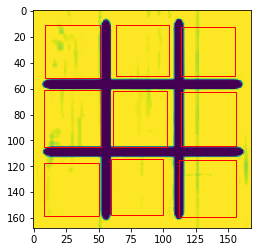

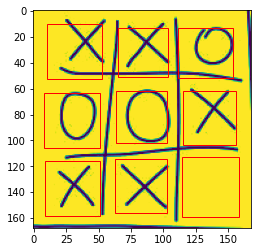

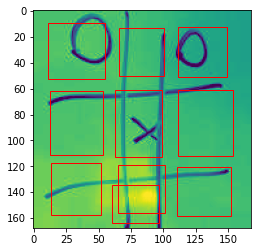

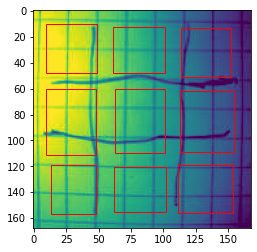

IndexError: ignored

In [29]:
show()